In [1]:
import operator as op
import src.ea.ea_lib as ea
import src.ea.problem_data as pb
import src.ea.utilities as ut
import random as rd
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#parameters
rd.seed(4)
generations = 200
population_size = 200
tournament_size = 5
mutation_percentage = 9
problem_name = "spect"
levels_back = 2
n_rows = 4
n_columns = 9
allow_input_to_output = False
inputs_available_to_all_columns = False
functions = [op.add,op.sub,op.mul,ut.safe_divide_one]
objectives = [
    ea.Objective(name="acc0", to_max = True, best=1, worst=0),
    ea.Objective(name="acc1", to_max = True, best=1, worst=0)
    ]
#The generation of creation of each individual is to be taken into account in cgp: the newest individuals are preferred over the oldest
generation_objective = ea.Objective(name="generation", to_max = True)

In [3]:
#Definition
dataset = pb.Dataset()
dataset.load_problem(name = problem_name)
nsgaii_objectives = ea.get_nsgaii_objectives()
cgp = ea.CGP_Representation(
            dataset.x_train.shape[1]
            ,1
            ,levels_back
            ,n_rows 
            ,n_columns
            ,allow_input_to_output
            ,inputs_available_to_all_columns
            ,*functions)

#Extraction of useful variables
labels = list(set(dataset.y_train))
print(labels)

[0, 1]


In [4]:
def evaluate_ind(ind):
    outputs = {}
    for i,data_row in enumerate(dataset.x_train):
        output_dict = ind.representation.evaluate(data_row = data_row)
        #Extracting the 0th index output gene
        output = output_dict[0]
        #The raw output needs to be transformed
        #transformed_output = ut.custom_round(output)
        transformed_output = ut.threshold_map(value = output,threshold = 0.5, output_up = labels[1], output_down = labels[0])
        outputs[i] = transformed_output
    #Each objective has its own evaluation method
    acc0 = ut.accuracy_in_label(y = dataset.y_train, y_output = outputs, label = 0)
    acc1 = ut.accuracy_in_label(y = dataset.y_train, y_output = outputs, label = 1)
    ind.update_evaluation(objective = objectives[0], value = acc0)
    ind.update_evaluation(objective = objectives[1], value = acc1)
    ind.update_semantics_all(semantics_all = outputs)

def evaluate_population(population):
    for ind in population:
        evaluate_ind(ind)

def print_logs(population):
    evals0 = []
    evals1 = []
    actives = []
    gens = []
    for i,ind in enumerate(population):
        evals0.append(ind.evaluations[objectives[0].name])
        evals1.append(ind.evaluations[objectives[1].name])
        actives.append(len(ind.representation.active_genotype))
        gens.append(ind.evaluations["generation"])
    print("Best", max([evals0[i]+evals1[i] for i in range(len(population))]))
    print("Mean acc0", np.mean(evals0))
    print("Mean acc1", np.mean(evals1))
    print("Mean gen", np.mean(gens))
    print("Mean active nodes", np.mean(actives))
    print("Skips", len([i for i in population if i.representation.evaluation_skipped]))
    print(" ")

In [5]:
#Initial generation
generation = 0

#Random initial population. Specific initial conditions for the population can be specified here
graphs = [cgp.create_random(seed = rd.random()) for _ in range(population_size)]

#create instances of Individual to be grouped in the population
parent_population = [ea.Individual(r) for r in graphs]

#Evaluate and sort the population according to non-domination
evaluate_population(population = parent_population)
sorted_nsga2_population = ea.fast_nondominated_sort(population = parent_population, conflicting_objectives = objectives, nsgaii_objectives = nsgaii_objectives)

#Create the offsprings of the initial generation
population = parent_population
for i in range(population_size):

    #Binary tournament selection is used in the initial generation only according to NSGA-II. The offspring is evaluated and added to the population
    parent_index = ea.tournament_selection_index(population_size = population_size, tournament_size = 2)
    parent = sorted_nsga2_population[parent_index]
    new_graph, active_altered = cgp.point_mutation(graph = parent.representation, percentage = mutation_percentage)
    offspring = ea.Individual(representation = new_graph)

    #If the active graph was not altered, the individual does not need to be evaluated again:
    if active_altered:
        evaluate_ind(offspring)
    else:
        offspring.representation.evaluation_skipped = True
        for objective in objectives:
            offspring.update_evaluation(objective = objective, value = parent.evaluations[objective.name])
        offspring.update_semantics_all(semantics_all = parent.semantics_all)
    population.append(offspring)

for ind in population:
    ind.update_evaluation(objective = generation_objective, value = generation)

In [10]:

def run_gen(population, current_gen):
    start_t = time.time()

    #Sorting the population. The generation of creation is the latest tiebreak (suggested in CGP), so fast_nondominated_sort cannot be used as it is

    """    
        ea.set_ranks(population = population, conflicting_objectives = objectives, front_objective = front_objective)
        ea.set_crowding_distances_by_front(population = population, conflicting_objectives = objectives, front_objective = front_objective, cd_objective = cd_objective)
        sorted_population = ea.sort_population(population = population, objectives = [front_objective, cd_objective, generation_objective])
    """
    sorted_population = ea.fast_nondominated_sort(population = population, conflicting_objectives = objectives, nsgaii_objectives = nsgaii_objectives)

    #Elitism
    parent_population = sorted_population[:population_size]

    #Offspring generation
    offspring_population = []
    for i in range(population_size):
        parent_index = ea.tournament_selection_index(population_size = len(parent_population), tournament_size = tournament_size)
        parent = parent_population[parent_index]
        new_graph, active_altered = cgp.point_mutation(graph = parent.representation, percentage = mutation_percentage)
        offspring = ea.Individual(representation = new_graph)

        #If the active graph was not altered, the individual does not need to be evaluated again:
        if active_altered:
            evaluate_ind(offspring)
        else:
            offspring.representation.evaluation_skipped = True
            for objective in objectives:
                offspring.update_evaluation(objective = objective, value = parent.evaluations[objective.name])
            offspring.update_semantics_all(semantics_all = parent.semantics_all)
        offspring_population.append(offspring)

    #Update the generation of creation of the offsprings
    for offspring in offspring_population:
        offspring.update_evaluation(objective = generation_objective, value = current_gen)

    #Formation of the population for the next gen
    population = offspring_population + parent_population

    print("Gen " , str(current_gen), " time: ", str(time.time()-start_t))
    #print_logs(population)
    return population


Gen  1  time:  2.2597548961639404


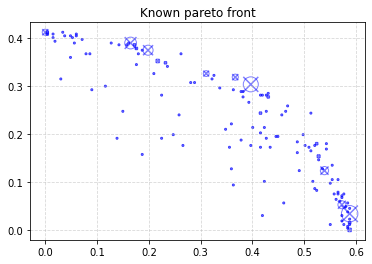

Gen  2  time:  2.102950096130371
Gen  3  time:  2.2345995903015137
Gen  4  time:  2.1249561309814453
Gen  5  time:  2.2394657135009766
Gen  6  time:  2.199129343032837
Gen  7  time:  2.622553825378418
Gen  8  time:  2.324082851409912
Gen  9  time:  2.5788700580596924
Gen  10  time:  2.59904408454895
Gen  11  time:  2.770709991455078
Gen  12  time:  2.62689208984375
Gen  13  time:  2.9021196365356445
Gen  14  time:  2.5123095512390137
Gen  15  time:  2.4962406158447266
Gen  16  time:  2.1741604804992676
Gen  17  time:  2.504399538040161
Gen  18  time:  2.245574951171875
Gen  19  time:  2.36616849899292
Gen  20  time:  2.4297187328338623
Gen  21  time:  2.3774468898773193
Gen  22  time:  2.5493786334991455
Gen  23  time:  2.252469539642334
Gen  24  time:  2.292616844177246
Gen  25  time:  2.0727334022521973
Gen  26  time:  2.1599416732788086
Gen  27  time:  2.2681725025177
Gen  28  time:  1.7880942821502686
Gen  29  time:  1.7189433574676514
Gen  30  time:  1.7410340309143066
Gen  31  ti

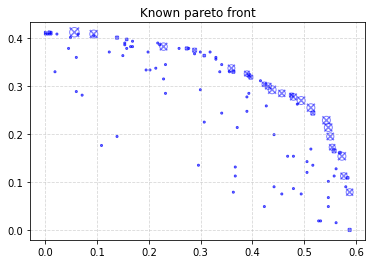

Gen  51  time:  1.8670334815979004
Gen  52  time:  1.9825692176818848
Gen  53  time:  2.065629720687866
Gen  54  time:  1.8454833030700684
Gen  55  time:  2.145036458969116
Gen  56  time:  2.1319453716278076
Gen  57  time:  1.8803246021270752
Gen  58  time:  1.7841565608978271
Gen  59  time:  1.7184741497039795
Gen  60  time:  1.8688812255859375
Gen  61  time:  2.1260643005371094
Gen  62  time:  1.969346284866333
Gen  63  time:  1.7490966320037842
Gen  64  time:  1.735586404800415
Gen  65  time:  1.8746273517608643
Gen  66  time:  2.092578411102295
Gen  67  time:  2.551097869873047
Gen  68  time:  2.422349691390991
Gen  69  time:  2.1033518314361572
Gen  70  time:  2.018126964569092
Gen  71  time:  1.8829517364501953
Gen  72  time:  2.0562098026275635
Gen  73  time:  2.3051114082336426
Gen  74  time:  1.9611015319824219
Gen  75  time:  1.8636293411254883
Gen  76  time:  1.9320528507232666
Gen  77  time:  2.114483118057251
Gen  78  time:  1.8593783378601074
Gen  79  time:  2.20905041694

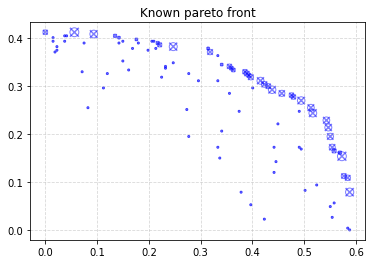

Gen  101  time:  2.0297112464904785
Gen  102  time:  2.283879280090332
Gen  103  time:  1.9516165256500244
Gen  104  time:  2.065991163253784
Gen  105  time:  1.9244110584259033
Gen  106  time:  2.0232505798339844
Gen  107  time:  1.792151927947998
Gen  108  time:  2.2580463886260986
Gen  109  time:  2.4641635417938232
Gen  110  time:  2.4314017295837402
Gen  111  time:  2.6041438579559326
Gen  112  time:  2.600686550140381
Gen  113  time:  2.6088688373565674
Gen  114  time:  2.9323842525482178
Gen  115  time:  2.565650701522827
Gen  116  time:  2.8103067874908447
Gen  117  time:  2.649883985519409
Gen  118  time:  2.933713436126709
Gen  119  time:  2.8019537925720215
Gen  120  time:  3.108090877532959
Gen  121  time:  2.517061471939087
Gen  122  time:  2.345630168914795
Gen  123  time:  2.2862632274627686
Gen  124  time:  2.412909507751465
Gen  125  time:  2.247575044631958
Gen  126  time:  2.5477404594421387
Gen  127  time:  2.351266860961914
Gen  128  time:  2.4464094638824463
Gen  

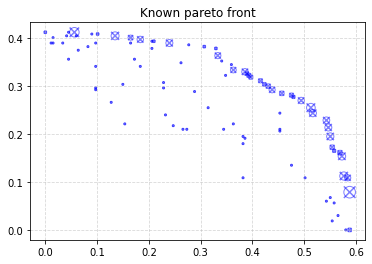

Gen  151  time:  2.3024065494537354
Gen  152  time:  2.2910959720611572
Gen  153  time:  2.5444722175598145
Gen  154  time:  2.7888970375061035
Gen  155  time:  2.1801958084106445
Gen  156  time:  1.9546997547149658
Gen  157  time:  2.0940611362457275
Gen  158  time:  2.411546468734741
Gen  159  time:  2.286283254623413
Gen  160  time:  2.7504355907440186
Gen  161  time:  1.9633042812347412
Gen  162  time:  2.500749349594116
Gen  163  time:  2.279731273651123
Gen  164  time:  2.498450756072998
Gen  165  time:  2.295250654220581
Gen  166  time:  2.4892780780792236
Gen  167  time:  2.0615031719207764
Gen  168  time:  2.3030643463134766
Gen  169  time:  2.4575183391571045
Gen  170  time:  2.541934013366699
Gen  171  time:  2.2177469730377197
Gen  172  time:  2.3386359214782715
Gen  173  time:  2.24360728263855
Gen  174  time:  2.2411532402038574
Gen  175  time:  2.3433988094329834
Gen  176  time:  2.292109727859497
Gen  177  time:  2.4412753582000732
Gen  178  time:  2.399960994720459
Gen

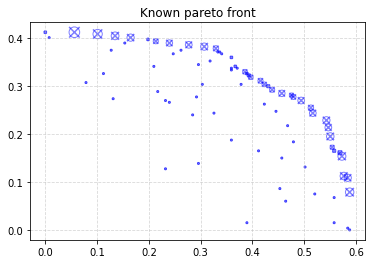

Gen  200  time:  2.9236721992492676


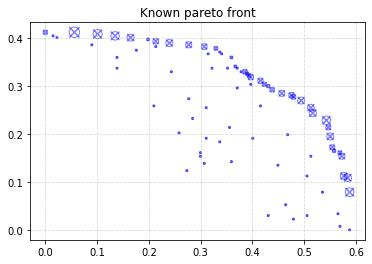

In [13]:
front_objective = nsgaii_objectives[0]
cd_objective = nsgaii_objectives[1]
for _ in range(generations):
    population = run_gen(population, generation)
    if generation in [1,50,100,150,200]:
        ea.plot_pareto(population, objectives, "size")
    generation += 1